In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from os import walk
#import re
from scipy.signal import savgol_filter
from scipy.signal import find_peaks, find_peaks_cwt, detrend
from scipy import signal

#import traceback
#import sys

#import matplotlib.gridspec as gridspec
#import matplotlib.style
#import matplotlib as mpl
#mpl.style.use('default')

from Methods.Methods import * # collection of processing methods in _Methods directory

In [3]:
def calculate_regression_line_stress_strain(Strain,Stress):
        #x = Strain, y = Stress_N_msquared
        #y = self.data['Stress_N_msquared'].values
        #x = self.data['Strain'].values

        #solve LLS Optimization problem min ||y - Phi*Theta||_2^2, Phi being [[1, x_0]^T,...,[1,x_N]^T]T
        Phi = np.array([np.ones(len(Strain)),Strain.values]).T
        Theta = np.linalg.inv(Phi.T @ Phi)@Phi.T @ Stress
        return Theta
    
def calculate_phase_shift(x,y):
    corr = np.correlate(x,y)
    return 

In [8]:
#obtain all sample names and respective paths in given directory
data_dir = r'D:\02_RESEARCH\08_Dynamic Mechanical Analysis\Messungen\Neuer Ordner\CSV'
dic = getFileContent(data_dir)

d = {}
df_rupture = {}
for key in dic.keys():
    if not (dic[key].endswith('4.CSV') or dic[key].endswith('3.CSV')):
    
        value = dic[key]
        d[key] = value
    if dic[key].endswith('4.CSV'):
        value = dic[key]
        df_rupture[key] = value
    #dic = [s.split('.')[0] for s in dic.keys()]
dic = d

In [5]:
#load geometry data from excel file
geometries = pd.read_excel(r'D:\02_RESEARCH\08_Dynamic Mechanical Analysis\Messungen\Neuer Ordner\DMA_BoseRolauffs_2020-12-22.xlsx',sheet_name='Geometrie')

#only keep data for cyclical experiments
geometries = geometries[geometries.zyklisch == 'x']
geometries = geometries[geometries.kept == 'x']
geometries.Probe = geometries.Probe.astype('Int32').astype('str')  
geometries['gel'] = geometries.Protein.str.replace('-','').str.lstrip('V')+'-'+geometries.Probe
geometries['Geldicke'] = 0.580

#only keep necessary columns
df_geometries = geometries[['gel','Gelbreite','Geldicke','Spaltbreite']]

In [6]:
names = ['Points','Elapsed_Time','Scan_Time','Disp','Load','E12_%','E22_%','Axial_cmd_V','Axial_err_%','Unnamed']

water1 = pd.read_csv(r'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\Wasser1.1.CSV', header = 1000, names=names,index_col=False)
water1.Disp = water1.Disp*0.001
water1['Load_sav'] = savgol_filter(water1.Load,21,1)
water1['Load_sav_det'] = detrend(water1.Load_sav)

water2 = pd.read_csv(r'D:\\02_RESEARCH\\08_Dynamic Mechanical Analysis\\Messungen\\Neuer Ordner\\CSV\\Wasser1.2.CSV', header = 1000, names=names,index_col=False)
water2.Disp = water2.Disp*0.001
water2['Load_sav'] = savgol_filter(water2.Load,11,1)
water2['Load_sav_det'] = detrend(water2.Load_sav)  

water1_offset, theta_water_1 = calculate_regression_line_stress_strain(Strain=water1.Disp,Stress=water1.Load_sav_det)
water2_offset, theta_water_2 = calculate_regression_line_stress_strain(Strain=water2.Disp,Stress=water2.Load_sav_det)

#print(theta_water_1, theta_water_2)

c:\users\alexander resch\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [7]:
from matplotlib import interactive
%matplotlib notebook 

list_thetas = []
list_thetas_corrected = []

activate_plot = False

for sample in dic.keys(): 
    
    try:
        #get path from sample dictionary
        path = dic[sample]

        header = 2500

        #print(sample)
        #load data into dataframe
        df = pd.read_csv(path,header=header,names=names,index_col=False)
        df['source'] = 'source'

        #drop duplicate row
        df = df.drop_duplicates(subset='Elapsed_Time',keep='first')

        #create walking continuous index
        df.Points = [i for i in range(1, len(df) + 1)]

        #keep 10000 points
        df = df[:10000]

        #convert displacement into meters
        df.Disp = 0.001*df.Disp

        #smoothen data 
        #if frequency == 1Hz ,   use 11 samples to smoothen data
        #if frequence == 0.1Hz, use 21 samples to smoothen data
        #else smoothen with 15 samples
        if sample.endswith('1.CSV'):
            df['Load_sav'] = savgol_filter(df.Load,21,1)

        elif sample.endswith('2.CSV'):
            df['Load_sav'] = savgol_filter(df.Load,11,1)

        else:
            df['Load_sav'] = savgol_filter(df.Load,15,1)


        #detrend data
        df['Load_sav_det'] = detrend(df.Load_sav)

        split_up_data = []
        thetas = []
        thetas_corrected = []
        
        if activate_plot:
            f = plt.figure(figsize=(8,6))
            ax = f.add_subplot(2,1,1)
            ax1 = f.add_subplot(2,1,2)
            plt.title(sample)
        
        
        for i in range(10):
            tmp = df[i*1000:(i+1)*1000]

            #calculate youngs modulus
            offset, theta_temp = calculate_regression_line_stress_strain(Strain=tmp.Disp,Stress=tmp.Load_sav_det)

            #correct for effects of water on measured force
            #don't correct the water plots
            if sample.startswith('Wasser1'):
                theta_corrected = theta_temp
                
            elif sample.endswith('1.CSV'):
                theta_corrected = theta_temp-theta_water_1
            
            elif sample.endswith('2.CSV') :
                theta_corrected = theta_temp-theta_water_2
            
            
            #plot data
            if activate_plot:
                tmp.Load.plot(ax=ax,alpha=0.25)
                tmp.Load_sav_det.plot(ax=ax)

                ##plot ellipses
                tmp.plot(x='Disp',y='Load_sav_det',ax=ax1,alpha=0.25)

                #plot youngs modulus
                x = tmp.Disp.values
                Phi = np.array([np.ones(len(x)),x]).T
                y = Phi@[offset, theta_temp]
                plt.plot(x,y)
            
            
            tmp['theta'] = theta_temp
            tmp['theta_corrected'] = theta_corrected

            #split_up_data.append(tmp)

            thetas.append(theta_temp)
            thetas_corrected.append(theta_corrected)

            
        print('sample raw: {}'.format(sample))
        print('E: max: {:.3f}, min: {:.3f}, mean: {:.3f}, std: {:.6f}'.format(np.max(thetas),
                                                                              np.min(thetas),
                                                                              np.mean(thetas),
                                                                              np.std(thetas)))
        print()
        print('sample corrected: {}'.format(sample))
        print('E: max: {:.3f}, min: {:.3f}, mean: {:.3f}, std: {:.6f}'.format(np.max(thetas_corrected),
                                                                              np.min(thetas_corrected),
                                                                              np.mean(thetas_corrected),
                                                                              np.std(thetas_corrected)))
        
        print()
        print()
        print()
        list_thetas.append([path,
                            np.max(thetas),
                            np.max(thetas_corrected),
                            np.min(thetas),
                            np.min(thetas_corrected),
                            np.mean(thetas),
                            np.mean(thetas_corrected),
                            np.std(thetas),
                            np.std(thetas_corrected),
                            sample, 
                            sample.split('.')[0]])

    except Exception as err:
        print('Error')
        print('File: ', dic[sample])
        print(traceback.format_exc())

df_youngs = pd.DataFrame(list_thetas, columns=['Path',
                                               'theta_Maximum',
                                               'theta_Maximum_corrected',
                                               'theta_Minimum',
                                               'theta_Minimum_corrected',
                                               'theta_Mean',
                                               'theta_Mean_corrected',
                                               'theta_Std',
                                               'theta_Std_corrected',
                                               'sample',
                                               'gel'])

df_full = pd.merge(df_youngs,df_geometries,how='outer',on='gel')

#transform linear coefficient theta into youngs modulus
df_full['E_Maximum'] = df_full.theta_Maximum*df_full.Spaltbreite*0.001/(df_full.Geldicke*0.001 * df_full.Gelbreite*0.001)
df_full['E_Maximum_corrected'] = df_full.theta_Maximum_corrected*df_full.Spaltbreite*0.001/(df_full.Geldicke*0.001 * df_full.Gelbreite*0.001)

df_full['E_Minimum'] = df_full.theta_Minimum*df_full.Spaltbreite*0.001/(df_full.Geldicke*0.001 * df_full.Gelbreite*0.001)
df_full['E_Minimum_corrected'] = df_full.theta_Minimum_corrected*df_full.Spaltbreite*0.001/(df_full.Geldicke*0.001 * df_full.Gelbreite*0.001)

df_full['E_Mean'] = df_full.theta_Mean*df_full.Spaltbreite*0.001/(df_full.Geldicke*0.001 * df_full.Gelbreite*0.001)
df_full['E_Mean_corrected'] = df_full.theta_Mean_corrected*df_full.Spaltbreite*0.001/(df_full.Geldicke*0.001 * df_full.Gelbreite*0.001)

df_full['E_Std'] = df_full.theta_Std*df_full.Spaltbreite*0.001/(df_full.Geldicke*0.001 * df_full.Gelbreite*0.001)
df_full['E_Std_corrected'] = df_full.theta_Std_corrected*df_full.Spaltbreite*0.001/(df_full.Geldicke*0.001 * df_full.Gelbreite*0.001)

df_full = df_full[['gel',
                   'sample',
                   'E_Maximum',
                   'E_Maximum_corrected',
                   'E_Minimum',
                   'E_Minimum_corrected',
                   'E_Mean',
                   'E_Mean_corrected',
                   'E_Std',
                   'E_Std_corrected']]
#calculate effect of water on youngs modulus in terms of gel


c:\users\alexander resch\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\alexander resch\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sample raw: 20-1.1.CSV
E: max: 231.224, min: 223.790, mean: 226.803, std: 2.640658

sample corrected: 20-1.1.CSV
E: max: 153.604, min: 146.170, mean: 149.183, std: 2.640658



sample raw: 20-1.2.CSV
E: max: 265.431, min: 256.296, mean: 260.095, std: 3.041788

sample corrected: 20-1.2.CSV
E: max: 178.437, min: 169.302, mean: 173.101, std: 3.041788



sample raw: 20-2.1.CSV
E: max: 351.914, min: 334.188, mean: 342.571, std: 6.620919

sample corrected: 20-2.1.CSV
E: max: 274.294, min: 256.568, mean: 264.951, std: 6.620919



sample raw: 20-2.2.CSV
E: max: 384.457, min: 379.380, mean: 382.897, std: 1.657851

sample corrected: 20-2.2.CSV
E: max: 297.463, min: 292.386, mean: 295.903, std: 1.657851



sample raw: 20-3.1.CSV
E: max: 403.971, min: 380.411, mean: 390.848, std: 7.072908

sample corrected: 20-3.1.CSV
E: max: 326.351, min: 302.791, mean: 313.229, std: 7.072908



sample raw: 20-3.2.CSV
E: max: 433.578, min: 422.484, mean: 427.583, std: 3.852535

sample corrected: 20-3.2.CSV
E: max:

NameError: name 'traceback' is not defined

In [11]:
df_full = df_full.round(2)
df_full.to_csv('youngs_moduli_korrigiert.csv',index=False,sep=';',decimal=',')

20-1.4.CSV


<IPython.core.display.Javascript object>


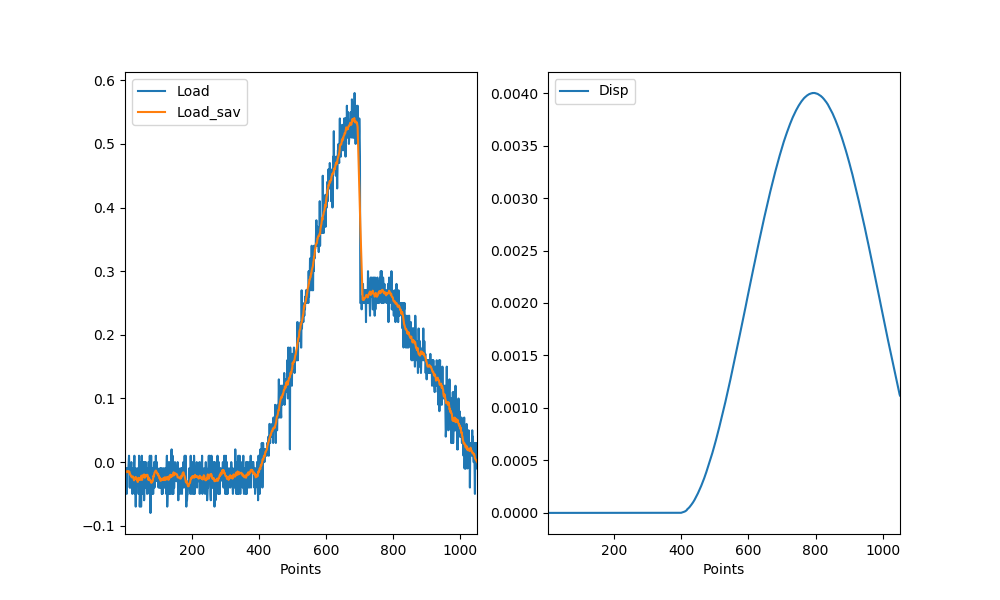

20-2.4.CSV


<IPython.core.display.Javascript object>


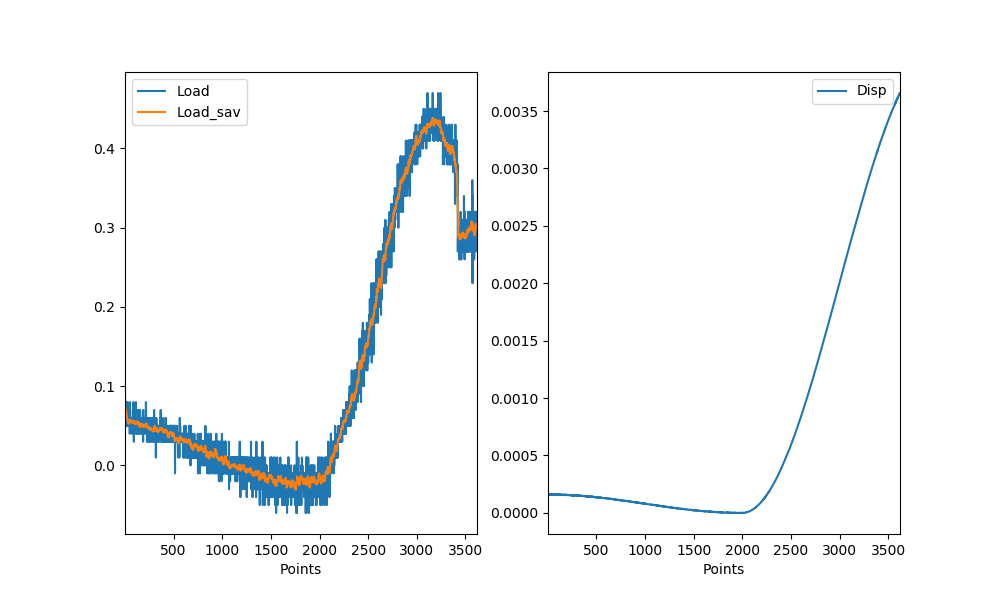

20-3.4.CSV


<IPython.core.display.Javascript object>


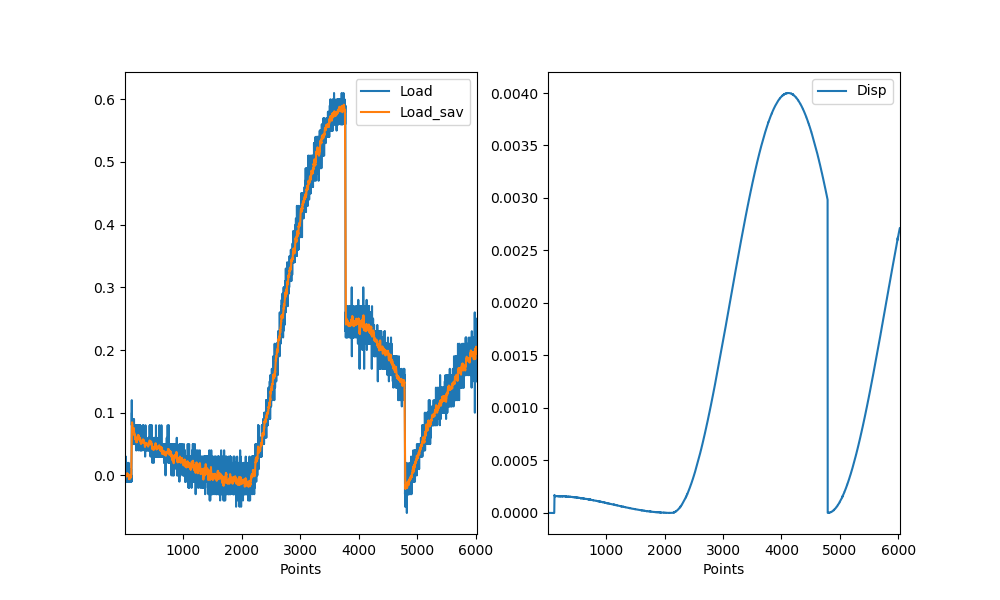

20-6.4.CSV


<IPython.core.display.Javascript object>


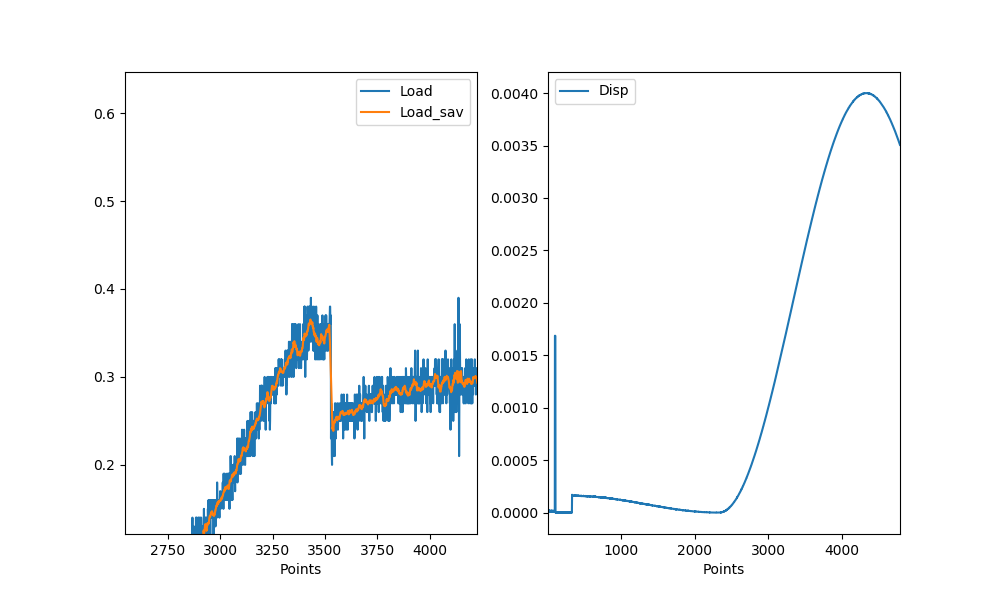

20RGD-1.4.CSV


<IPython.core.display.Javascript object>


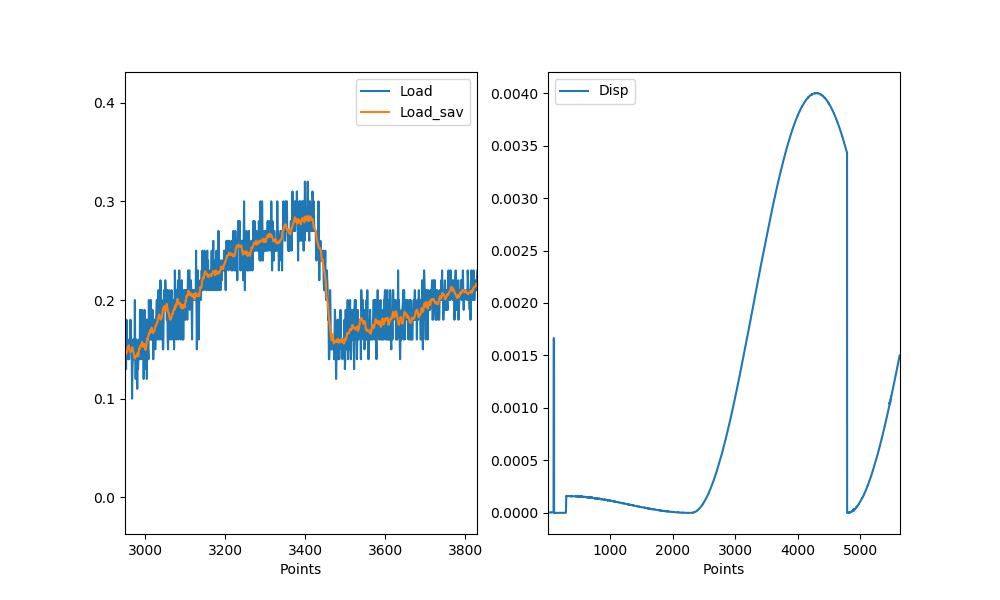

20RGD-2.4.CSV


<IPython.core.display.Javascript object>


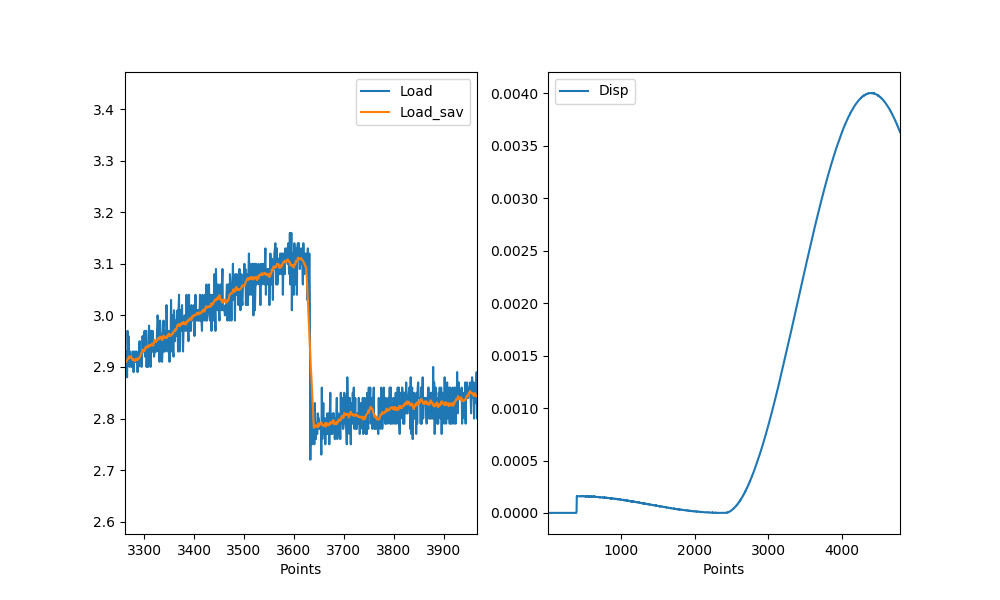

20RGD-3.4.CSV


<IPython.core.display.Javascript object>


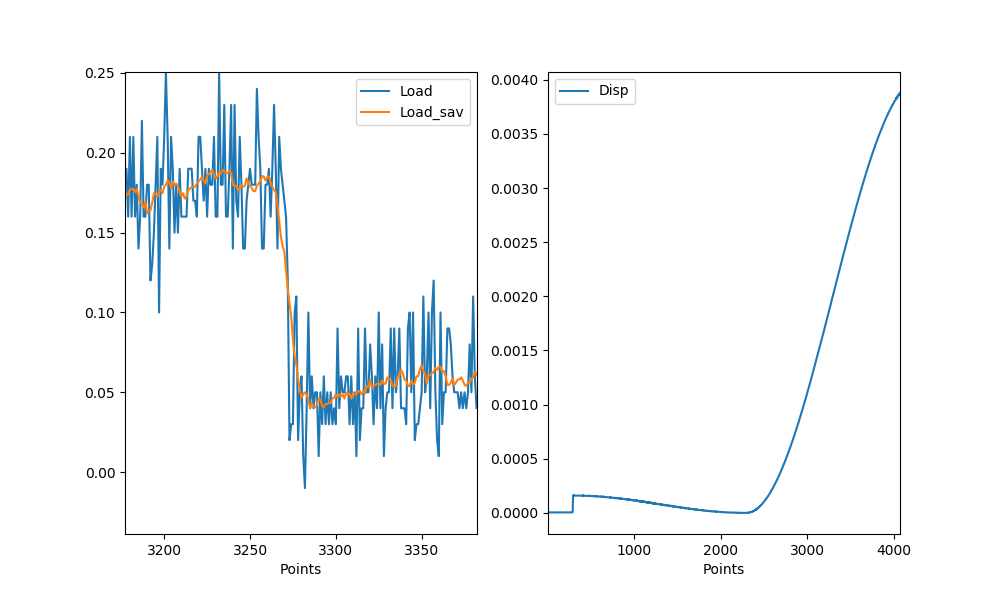

20RGD-5.4.CSV


<IPython.core.display.Javascript object>


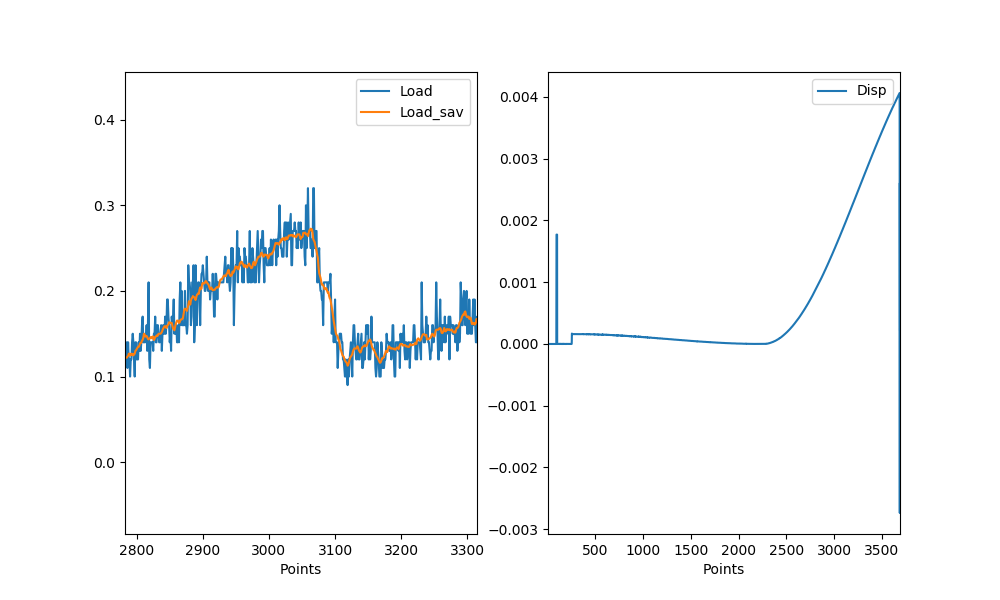

20RGD-6.4.CSV


<IPython.core.display.Javascript object>


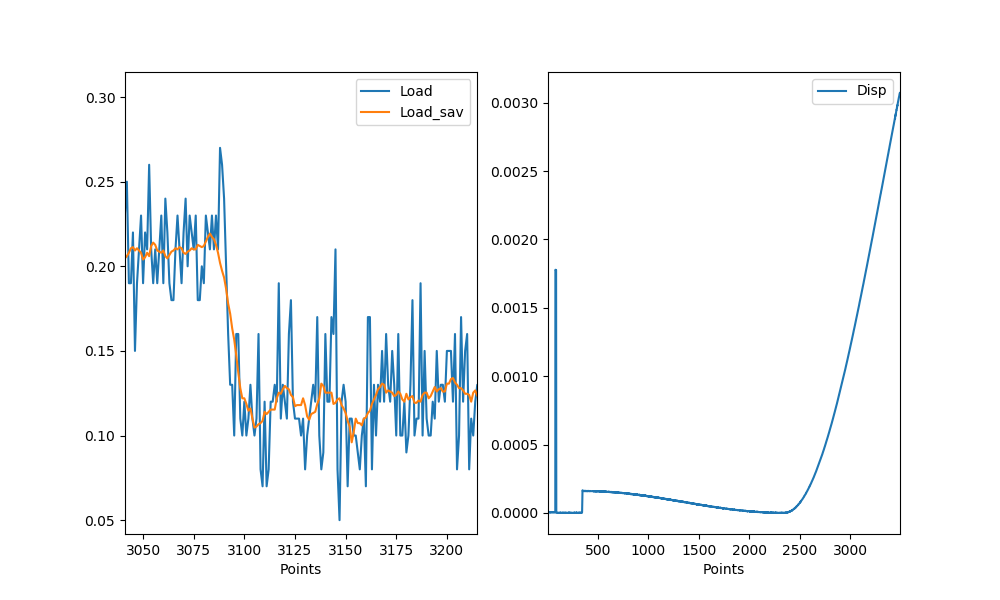

20RGD-7.4.CSV


<IPython.core.display.Javascript object>


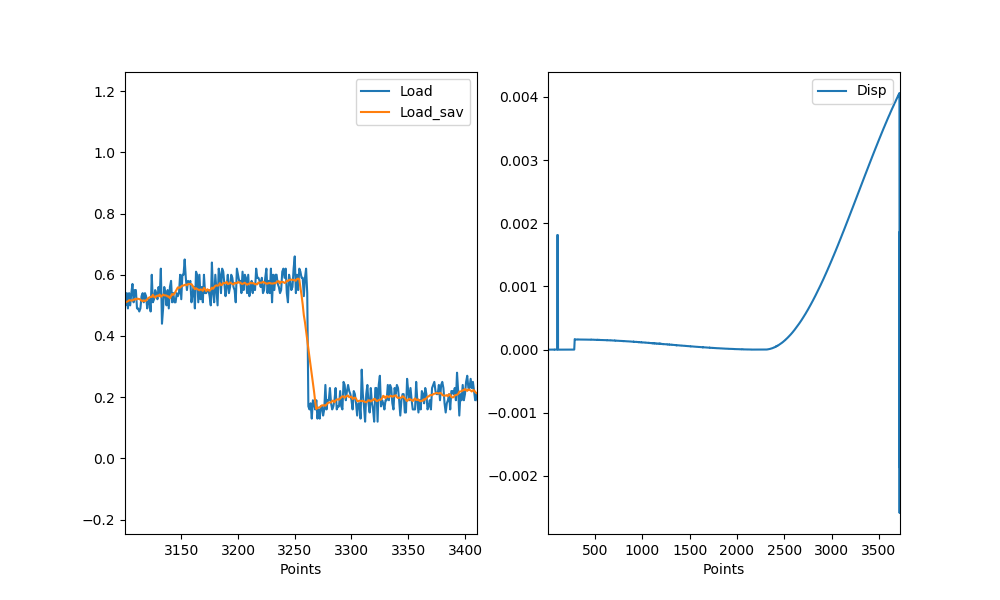

20RGD-8.4.CSV


<IPython.core.display.Javascript object>


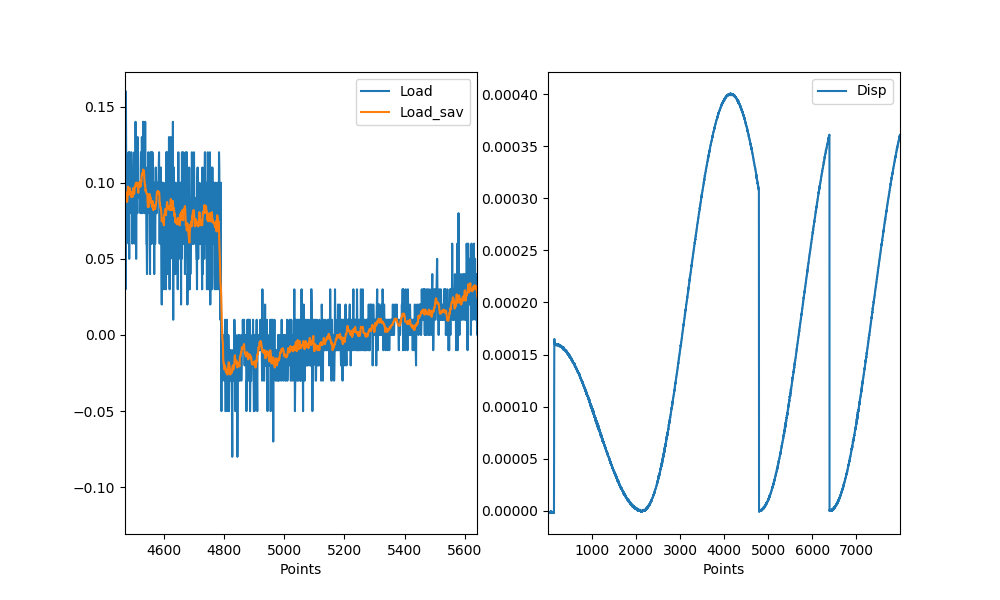

40-1.4.CSV


<IPython.core.display.Javascript object>


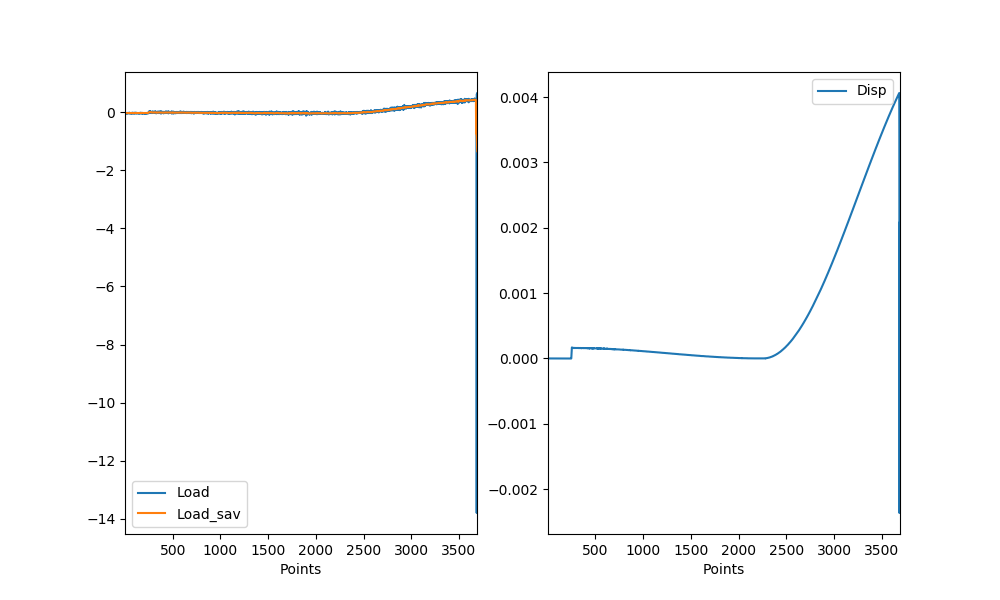

40-2.4.CSV


<IPython.core.display.Javascript object>


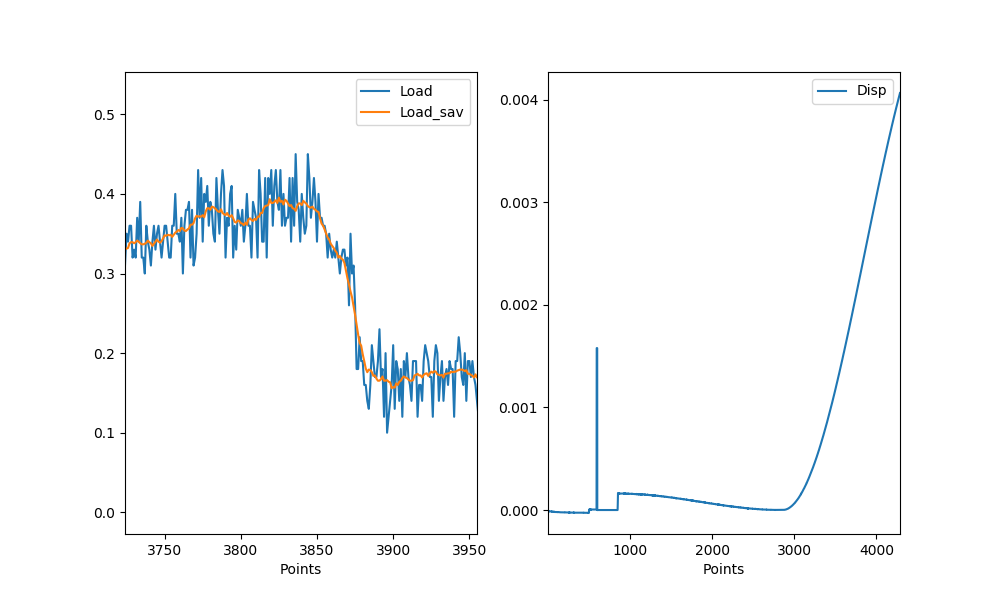

40-3.4.CSV


<IPython.core.display.Javascript object>


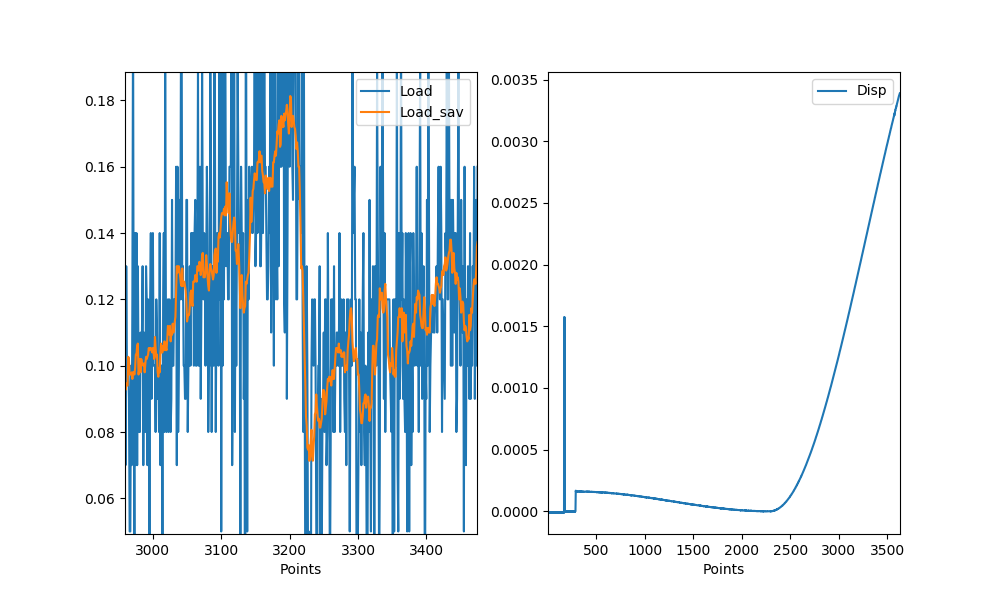

40-4.4.CSV


<IPython.core.display.Javascript object>


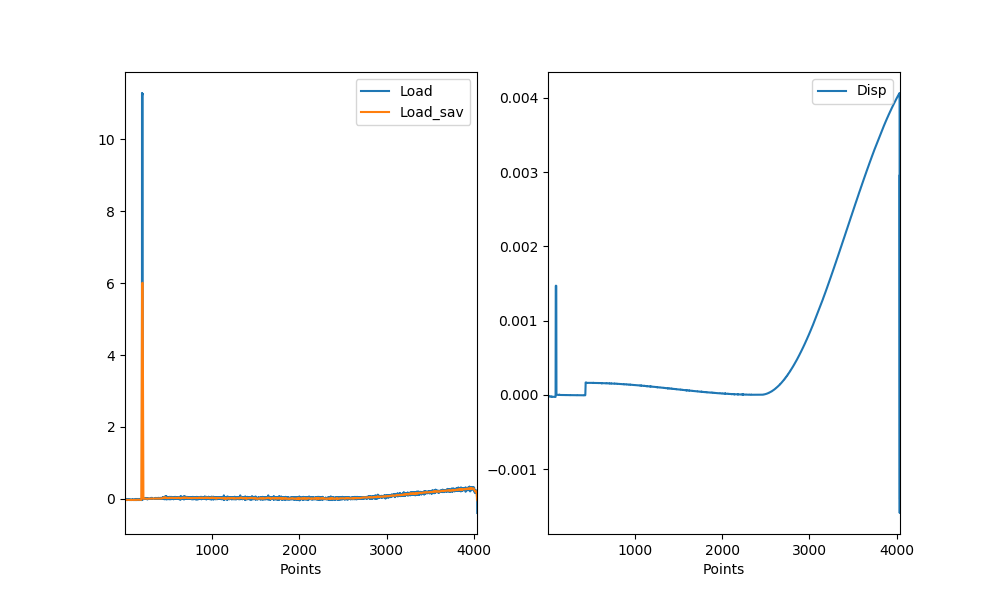

40-5.4.CSV


<IPython.core.display.Javascript object>


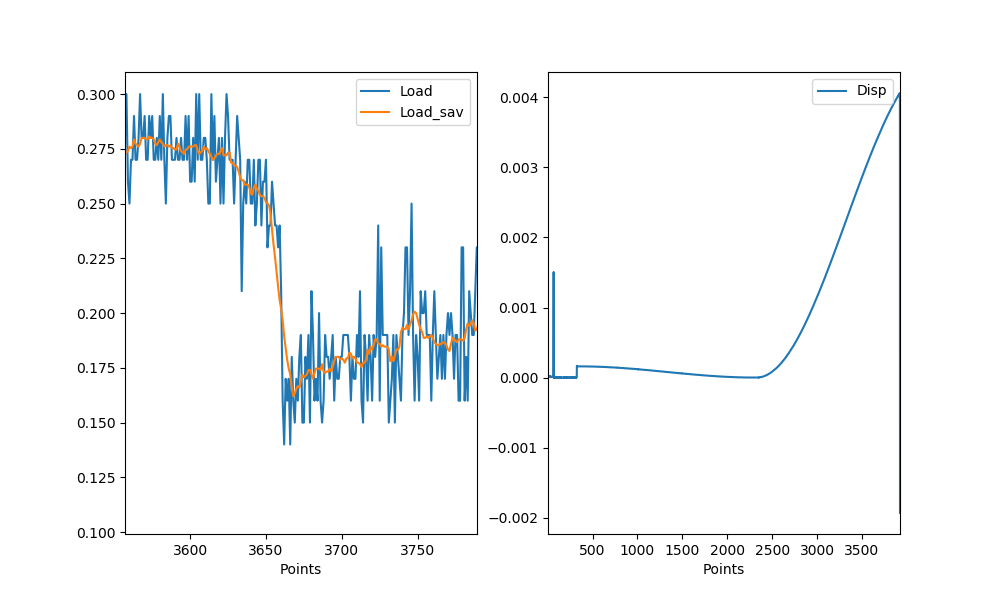

40-6.4.CSV


<IPython.core.display.Javascript object>


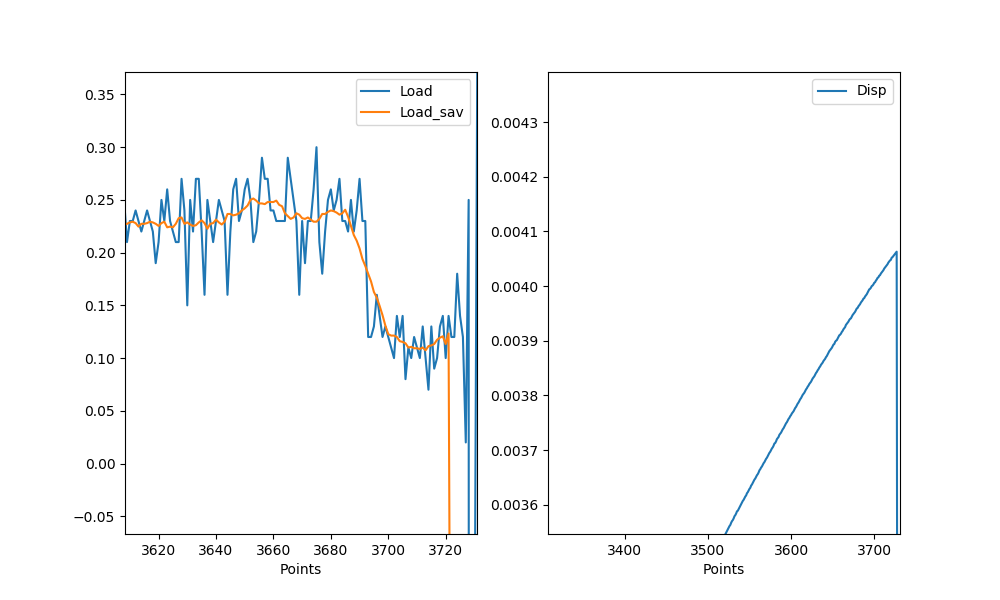

40-7.4.CSV


<IPython.core.display.Javascript object>


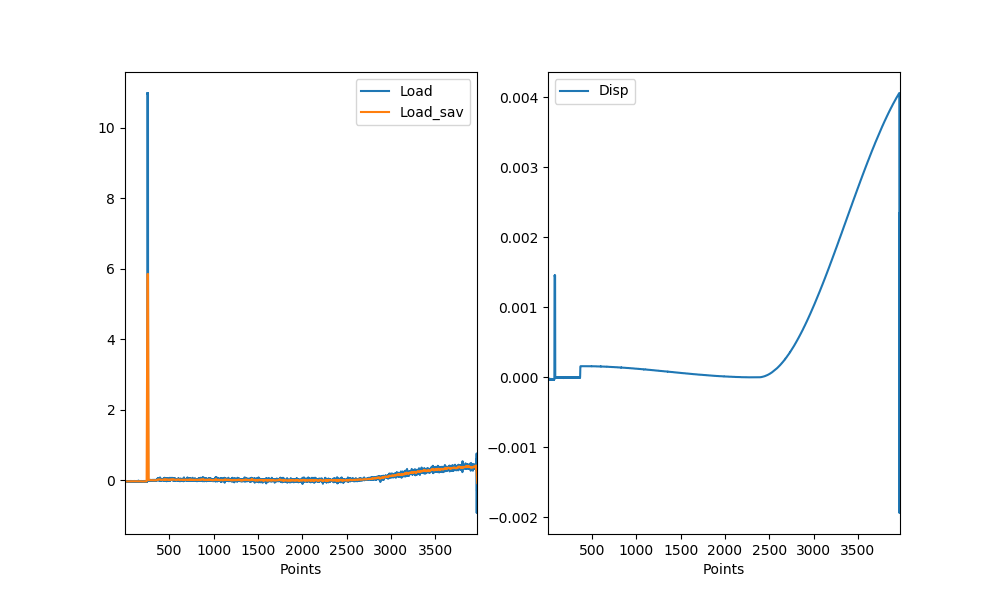

40-8.4.CSV


<IPython.core.display.Javascript object>


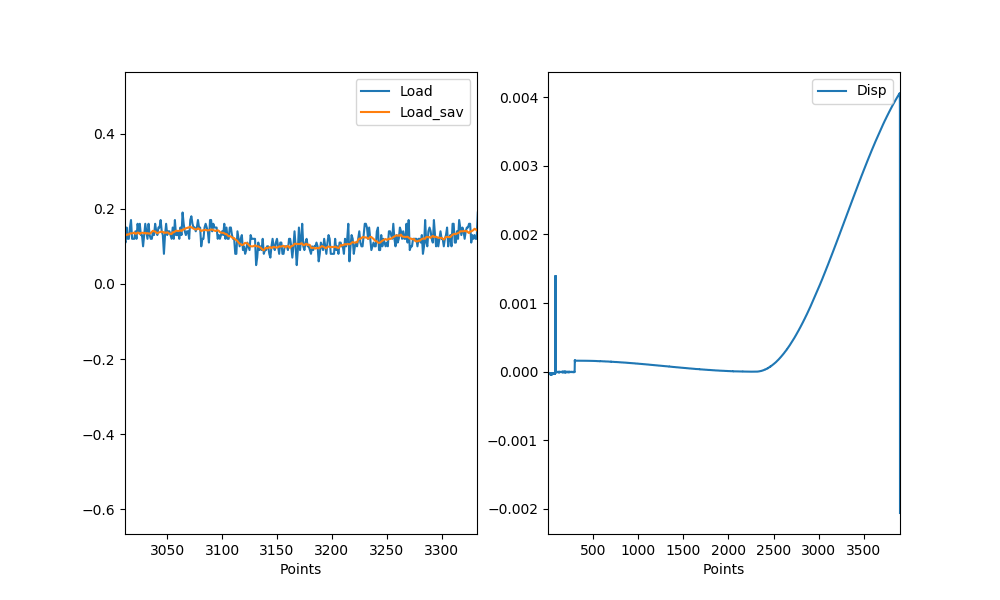

40RGD-1.4.CSV


<IPython.core.display.Javascript object>


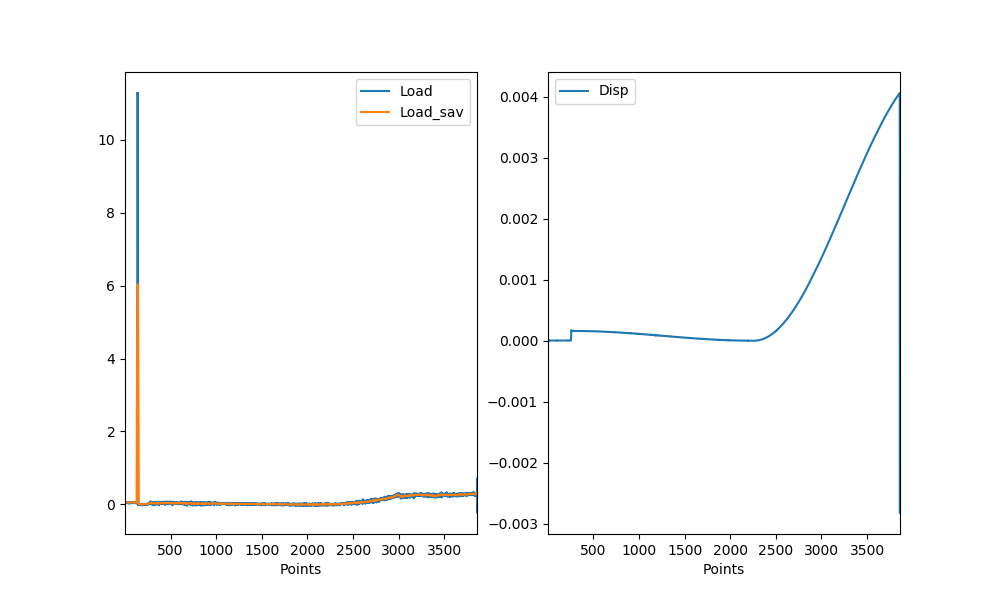

40RGD-2.4.CSV


c:\users\alexander resch\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


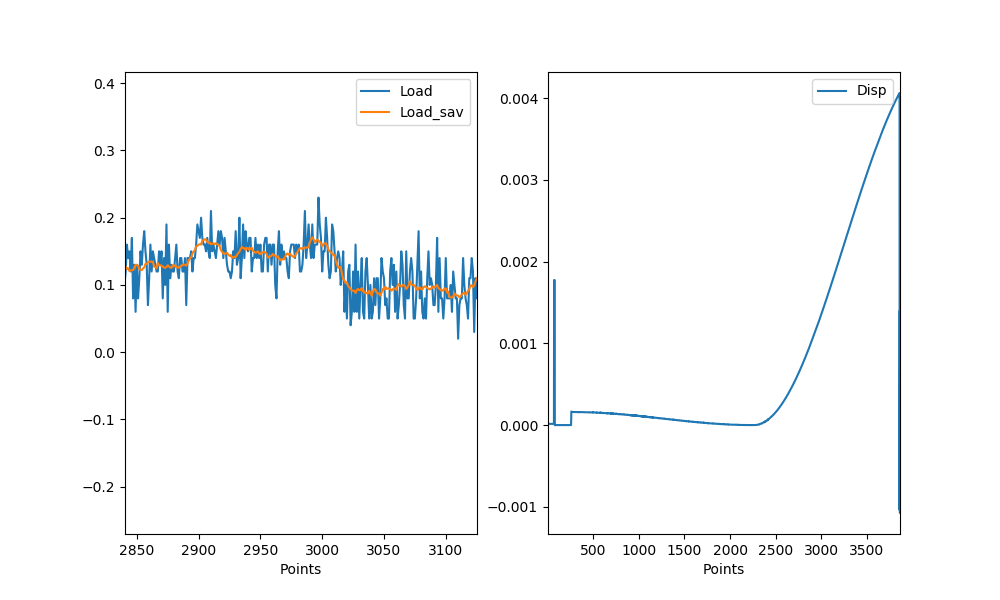

40RGD-3.4.CSV


<IPython.core.display.Javascript object>


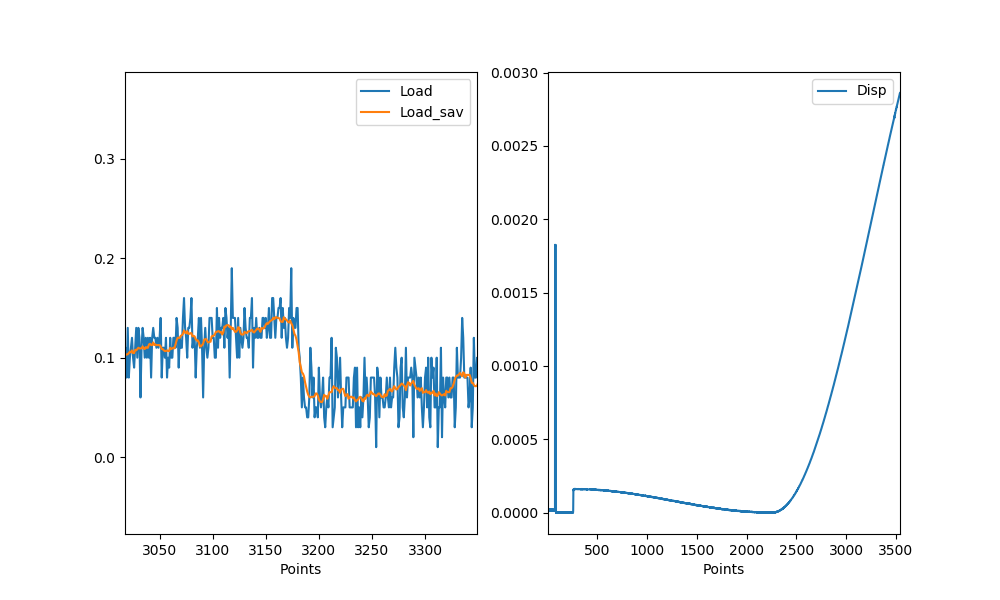

40RGD-4.4.CSV


<IPython.core.display.Javascript object>


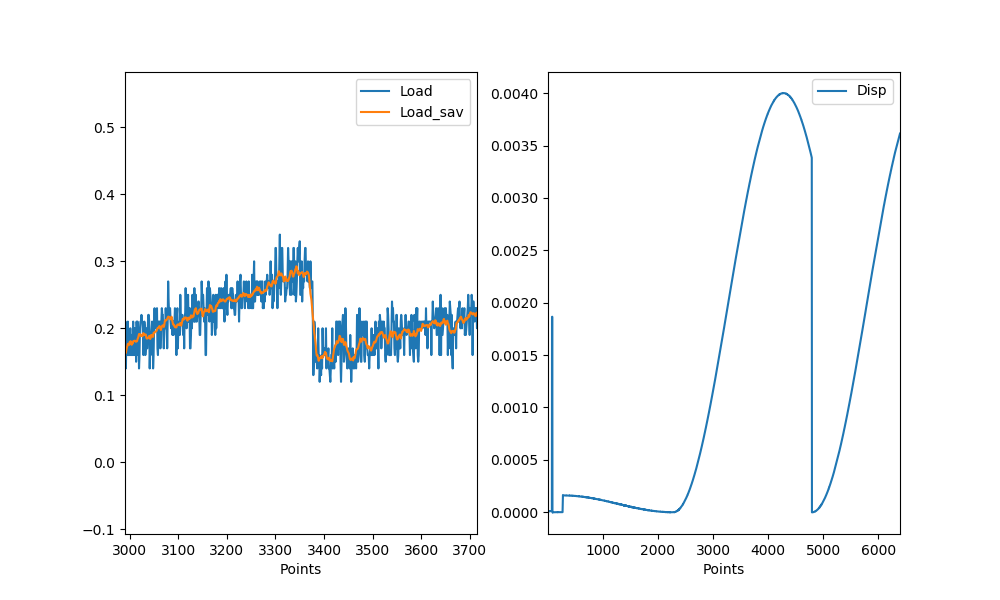

40RGD-5.4.CSV


<IPython.core.display.Javascript object>


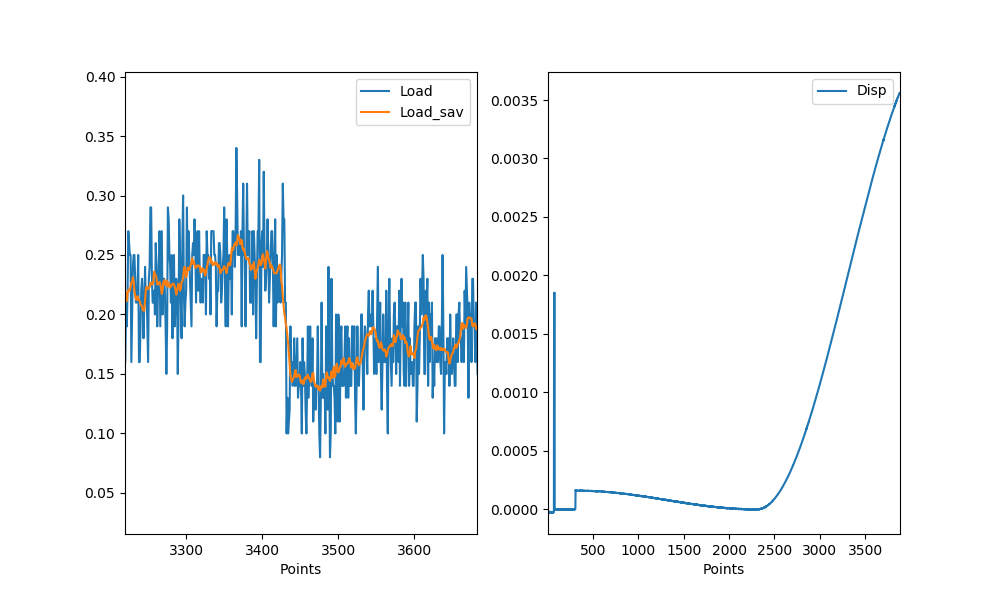

40RGD-6.4.CSV


<IPython.core.display.Javascript object>


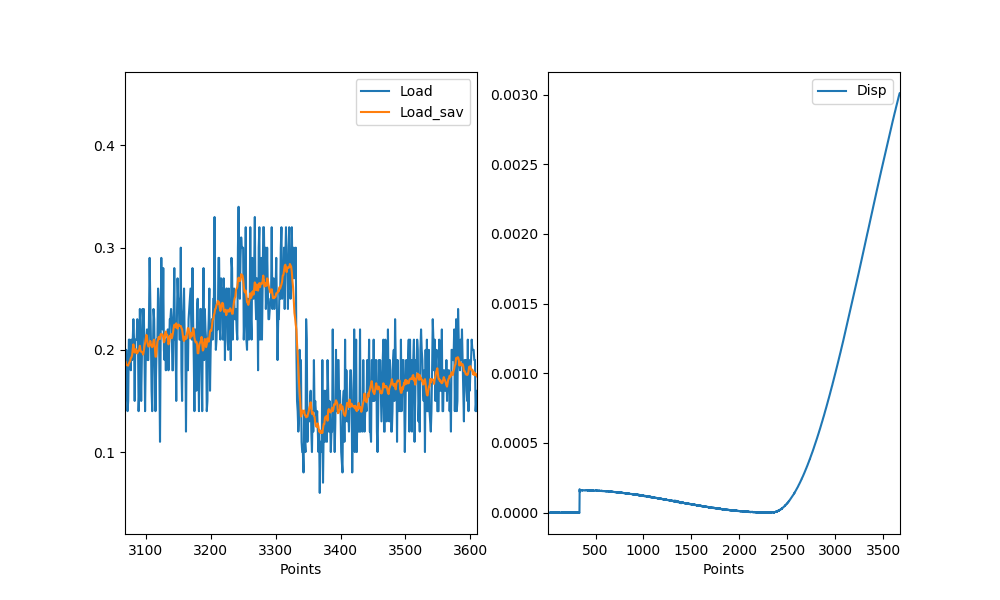

40RGD-7.4.CSV


<IPython.core.display.Javascript object>


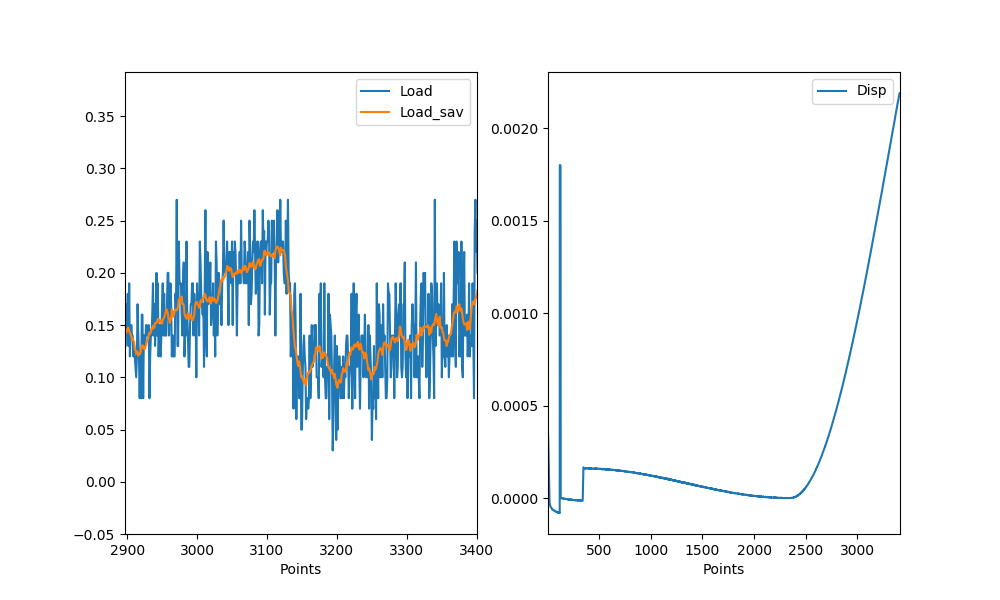

In [75]:
#these are the manually extracted points of rupture in the data. from those the strain and stress can be calculated 
Points_of_rupture = [682,3200,3715,3715,3515,3615,3240,3060,3080,3250,4773,3677,3822,3200,3990,3560,
3685,3950,3070,2991,2990,3157,3325,3420,3306,311]

list_of_ruptures = []
k=0
for sample in df_rupture.keys(): 
    
    try:
        #get path from sample dictionary
        path = df_rupture[sample]
        header = 10

        #print(sample)
        #load data into dataframe
        df = pd.read_csv(path,header=header,names=names,index_col=False)
        #df['source'] = 'source'

        #drop duplicate row
        df = df.drop_duplicates(subset='Elapsed_Time',keep='first')

        #create walking continuous index
        df.Points = [i for i in range(1, len(df) + 1)]

        #keep 10000 points
        #df = df[:10000]

        #convert displacement into meters
        df.Disp = 0.001*df.Disp
        
        #smoothen data
        df['Load_sav'] = savgol_filter(df.Load,15,1)
        
        '''
        force_at_rupture = df.Load_sav[df.Points == Points_of_rupture[k]]
        displacement_at_rupture = df.Disp[df.Points == Points_of_rupture[k]]
        
        list_of_ruptures.append([path,
                                 force_at_rupture,
                                 displacement_at_rupture,
                                 sample, 
                                 sample.split('.')[0]])

        '''
        
        print(sample)
        f = plt.figure(figsize=(10,6))
        ax1 = f.add_subplot(1,2,1)
        ax2 = f.add_subplot(1,2,2)
        df.plot(x='Points',y=['Load','Load_sav'],ax=ax1)
        df.plot(x='Points',y=['Disp'],ax=ax2)
        
    
    except Exception as err:
        
        print('Error')
        print('File: ', dic[sample])
        print(traceback.format_exc())
    #iterate through rupture point data    
    k+=1
    
df_r = pd.DataFrame(list_of_ruptures, columns=['Path',
                                               'Force',
                                               'Disp',
                                               'sample',
                                               'gel'])        

In [41]:
df_r

,Path,Force,Disp,sample,gel
0,D:\02_RESEARCH\08_Dynamic Mechanical Analysis\...,"681 0.536667 Name: Load_sav, dtype: float64","681 0.003278 Name: Disp, dtype: float64",20-1.4.CSV,20-1
1,D:\02_RESEARCH\08_Dynamic Mechanical Analysis\...,"3201 0.434 Name: Load_sav, dtype: float64","3201 0.002623 Name: Disp, dtype: float64",20-2.4.CSV,20-2
2,D:\02_RESEARCH\08_Dynamic Mechanical Analysis\...,"3716 0.584667 Name: Load_sav, dtype: float64","3716 0.003613 Name: Disp, dtype: float64",20-3.4.CSV,20-3
3,D:\02_RESEARCH\08_Dynamic Mechanical Analysis\...,"3716 0.273333 Name: Load_sav, dtype: float64","3716 0.003131 Name: Disp, dtype: float64",20-6.4.CSV,20-6
4,D:\02_RESEARCH\08_Dynamic Mechanical Analysis\...,"3516 0.169333 Name: Load_sav, dtype: float64","3516 0.002672 Name: Disp, dtype: float64",20RGD-1.4.CSV,20RGD-1
5,D:\02_RESEARCH\08_Dynamic Mechanical Analysis\...,"3616 3.110667 Name: Load_sav, dtype: float64","3616 0.002675 Name: Disp, dtype: float64",20RGD-2.4.CSV,20RGD-2
6,D:\02_RESEARCH\08_Dynamic Mechanical Analysis\...,"3241 0.18 Name: Load_sav, dtype: float64","3241 0.001831 Name: Disp, dtype: float64",20RGD-3.4.CSV,20RGD-3
7,D:\02_RESEARCH\08_Dynamic Mechanical Analysis\...,"3060 0.267333 Name: Load_sav, dtype: float64","3060 0.001748 Name: Disp, dtype: float64",20RGD-5.4.CSV,20RGD-5
8,D:\02_RESEARCH\08_Dynamic Mechanical Analysis\...,"3080 0.212 Name: Load_sav, dtype: float64","3080 0.001487 Name: Disp, dtype: float64",20RGD-6.4.CSV,20RGD-6
9,D:\02_RESEARCH\08_Dynamic Mechanical Analysis\...,"3251 0.581333 Name: Load_sav, dtype: float64","3251 0.002359 Name: Disp, dtype: float64",20RGD-7.4.CSV,20RGD-7


In [68]:
df.Load_sav.iloc[Points_of_rupture[k-1]+200]


0.025333333333333336

In [55]:
Points_of_rupture[k-1]+10

321